DATA LOADING

In [1]:
"""
SFOAE peak-picking algorithm

Author: havlajos
Created: 18/10/2022
Last Update: 07/07/2023

Description: Analysis of the phase-gradient delay of SFOAE data using the peak-picking algorithm.
"""

# library importing
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# script importing
from peak_picking import *
from gradient_delay import *

# SFOAE data loading - CHOOSE !
FILENAME = 'data/SFOAE/sfoae30dBg130TM45R19rs2.mat'
mat_SFOAE = scipy.io.loadmat(FILENAME)

# ! CHANGE THE DICT KEYS !
freq_SFOAE = mat_SFOAE['Fvect'].flatten()  # frequency axis
SFOAE = mat_SFOAE['oaeNum30'].flatten()  # SFOAE wave
CRcomp = mat_SFOAE['CRc30'].flatten()  # CR component
NLcomp = mat_SFOAE['Yunl30'].flatten()  # NL component

freq_range_SFOAE = np.size(freq_SFOAE)  # maximum index on the frequency axis


CALCULATING NEEDED VALUES

SFOAE

In [2]:
SPL_SFOAE = 20*np.log10(np.abs(SFOAE))  # sound pressure level

# peak picking
maximas_SFOAE = findLocalMaxima(SPL_SFOAE)

shift = 1  # 3 points around all peaks (the peak is included)
ext_maximas_SFOAE = peakNeighbours(maximas_SFOAE, shift, freq_range_SFOAE)

grad_delay_SFOAE = calcDelay(freq_SFOAE, SFOAE)


CR COMPONENT

In [3]:
freq_range_CR = freq_range_SFOAE
freq_CR = freq_SFOAE
SPL_CR = 20*np.log10(np.abs(CRcomp))  # sound pressure level

# peak picking
maximas_CR = findLocalMaxima(SPL_CR)
shift = 1  # 3 points around all peaks (the peak is included)
ext_maximas_CR = peakNeighbours(maximas_CR, shift, freq_range_CR)

grad_delay_CR = calcDelay(freq_CR, CRcomp)


NL COMPONENT

In [4]:
freq_range_NL = freq_range_SFOAE
freq_NL = freq_SFOAE
SPL_NL = 20*np.log10(np.abs(NLcomp))  # sound pressure level

# peak picking
maximas_NL = findLocalMaxima(SPL_NL)
shift = 1  # 3 points around all peaks (the peak is included)
ext_maximas_NL = peakNeighbours(maximas_NL, shift, freq_range_NL)

grad_delay_NL = calcDelay(freq_NL, NLcomp)


ISOLATED INTENSITY

In [5]:
from isoint import *

ISOINT_start, ISOINT_stop, ISOINT_step = 1000, 3200, 200

freq_ISOINT_list = []
GD_ISOINT_list = []
max_idx_ISOINT_list = []

for i in range(ISOINT_start, ISOINT_stop + 1, ISOINT_step):
    filename = f"data/isointFT/isoint_{i}Hz_Level_30dB_TM45130.mat"
    freq_ISOINT, group_delay_ISOINT, max_idx_ISOINT = processIsoInt(filename)

    freq_ISOINT_list.append(freq_ISOINT)
    GD_ISOINT_list.append(group_delay_ISOINT)
    max_idx_ISOINT_list.append(max_idx_ISOINT)

PLOTTING

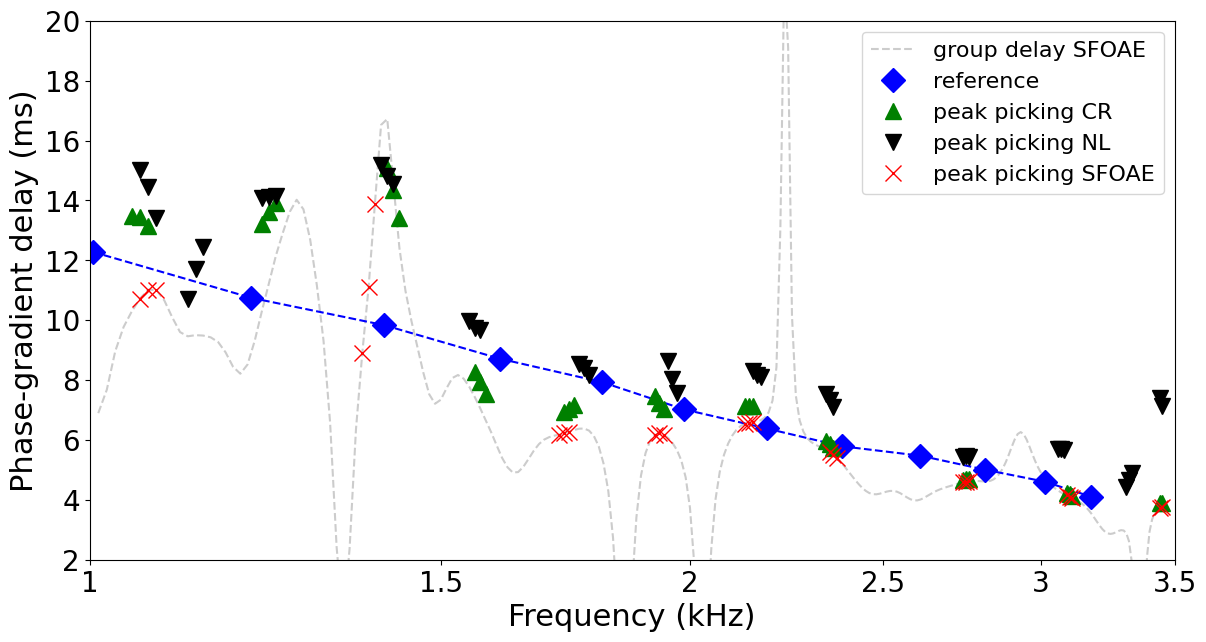

In [6]:
from matplotlib.ticker import FixedLocator, FixedFormatter

fig, ax = plt.subplots(figsize=(14, 7))

# multiplying by 1000 because of the transfer to miliseconds
ax.plot(freq_SFOAE/1000, 1000*grad_delay_SFOAE, '0.8',
        linestyle='--', label='group delay SFOAE')

# reference values
for i, freq_ISOINT in enumerate(freq_ISOINT_list):
    max_idx = max_idx_ISOINT_list[i]
    grad_delay_ISOINT = GD_ISOINT_list[i]
    ax.plot(freq_ISOINT[max_idx]/1000, 1000*grad_delay_ISOINT[max_idx],
            "bD", markersize=12, label='reference' if i == 0 else None)
    if i > 0:  # connect points starting from the second point
        ax.plot([freq_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]]/1000, freq_ISOINT[max_idx]/1000],
                [1000*GD_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]],
                    1000*grad_delay_ISOINT[max_idx]],
                "b--")

ax.plot(freq_CR[ext_maximas_CR]/1000, 1000*grad_delay_CR[ext_maximas_CR],
        "g^", markersize=12, label='peak picking CR')

ax.plot(freq_NL[ext_maximas_NL]/1000, 1000*grad_delay_NL[ext_maximas_NL],
        "kv", markersize=12, label='peak picking NL')

ax.plot(freq_SFOAE[ext_maximas_SFOAE]/1000, 1000*grad_delay_SFOAE[ext_maximas_SFOAE],
        "rx", markersize=12, label='peak picking SFOAE')

ax.set_xscale('log')
ax.set_xlim([1, 3.5])
# Customize the tick labels on the x-axis
x_ticks = [1, 1.5, 2, 2.5, 3, 3.5]
ax.xaxis.set_major_locator(FixedLocator(x_ticks))
ax.xaxis.set_major_formatter(FixedFormatter(x_ticks))
ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_ylim([2, 20])
ax.set_xlabel('Frequency (kHz)', fontdict={"fontsize": 22})
ax.set_ylabel('Phase-gradient delay (ms)', fontdict={"fontsize": 22})
ax.legend(fontsize=16)

plt.rcParams['font.family'] = 'Times New Roman'
#plt.savefig('peak_picking_SFOAE.png', dpi=500)
plt.show()
